In [7]:
%pwd

'E:\\soft\\anaconda3\\envs\\tensorflow310\\1projects'

In [6]:
import zipfile

with zipfile.ZipFile("E:\\soft\\anaconda3\\envs\\tensorflow310\\1projects\\datasets\\img_align_celeba.zip", 'r') as zip_ref:
    zip_ref.extractall("E:\\soft\\anaconda3\\envs\\tensorflow310\\1projects\\datasets\\celeba_gan")

In [43]:
from tensorflow import keras
dataset = keras.utils.image_dataset_from_directory(
    "datasets\\celeba_gan",
    label_mode=None,
    image_size=(64, 64),
    batch_size=16,
    # smart_resize=True
)

Found 202599 files belonging to 1 classes.


In [44]:
dataset = dataset.map(lambda x: x / 255)

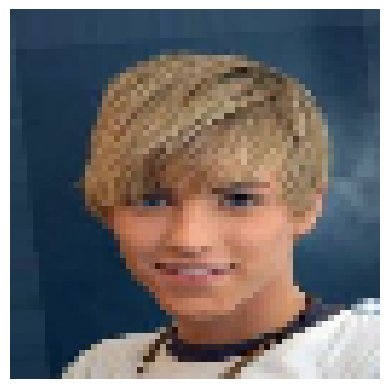

In [48]:
import matplotlib.pyplot as plt
for x in dataset:
  plt.axis("off")
  plt.imshow((x.numpy() * 255).astype("int32")[4])
  break

In [49]:
from tensorflow.keras import layers

discriminator = keras.Sequential(
    [
        keras.Input(shape=(64, 64, 3)),
        layers.Conv2D(64, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(1, activation="sigmoid"),
    ],
    name="discriminator",
)

In [50]:
latent_dim = 128

generator = keras.Sequential(
    [
        keras.Input(shape=(latent_dim,)),
        layers.Dense(8 * 8 * 128),
        layers.Reshape((8, 8, 128)),
        layers.Conv2DTranspose(128, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(256, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2DTranspose(512, kernel_size=4, strides=2, padding="same"),
        layers.LeakyReLU(alpha=0.2),
        layers.Conv2D(3, kernel_size=5, padding="same", activation="sigmoid"),
    ],
    name="generator",
)

In [51]:
import tensorflow as tf
class GAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_loss_metric = keras.metrics.Mean(name="d_loss")
        self.g_loss_metric = keras.metrics.Mean(name="g_loss")

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(GAN,self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    @property
    def metrics(self):
        return [self.d_loss_metric, self.g_loss_metric]

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )
        generated_images = self.generator(random_latent_vectors)
        combined_images = tf.concat([generated_images, real_images], axis=0)
        labels = tf.concat(
            [tf.ones((batch_size, 1)), tf.zeros((batch_size, 1))], axis=0
        )
        labels += 0.05 * tf.random.uniform(tf.shape(labels))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )
        random_latent_vectors = tf.random.normal(
            shape=(batch_size, self.latent_dim)
        )
        misleading_labels = tf.zeros((batch_size, 1))

        with tf.GradientTape() as tape:
            predictions = self.discriminator(self.generator(random_latent_vectors))
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(
            zip(grads, self.generator.trainable_weights)
        )

        self.d_loss_metric.update_state(d_loss)
        self.g_loss_metric.update_state(g_loss)
        return {
            "d_loss": self.d_loss_metric.result(),
            "g_loss": self.g_loss_metric.result(),
        }

In [52]:
class GANMonitor(keras.callbacks.Callback):
    def __init__(self, num_img=3, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim

    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images *= 255
        generated_images.numpy()

        for i in range(self.num_img):
            img = keras.utils.array_to_img(generated_images[i])
            img.save(f"generated_img_{epoch:03d}_{i}.png")

In [53]:
epochs = 5

gan = GAN(discriminator=discriminator, generator=generator, latent_dim=latent_dim)
gan.compile(
    d_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    g_optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss_fn=keras.losses.BinaryCrossentropy(),
)

history = gan.fit(
    dataset, 
    epochs=epochs, 
    callbacks=[GANMonitor(num_img=10, latent_dim=latent_dim)]
)

Epoch 1/5
12663/12663 [==============================] - 2783s 220ms/step - d_loss: 0.6404 - g_loss: 1.0589
Epoch 2/5
12663/12663 [==============================] - 2770s 219ms/step - d_loss: 0.6484 - g_loss: 1.0260
Epoch 3/5
12663/12663 [==============================] - 2771s 219ms/step - d_loss: 0.6242 - g_loss: 1.1012
Epoch 4/5
12663/12663 [==============================] - 2766s 218ms/step - d_loss: 0.6747 - g_loss: 0.9078
Epoch 5/5
12663/12663 [==============================] - 2781s 220ms/step - d_loss: 0.6792 - g_loss: 0.8778


In [54]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import os

num_img = 10
epoch = 1

for i in range(num_img):
    img_path = f"/content/generated_img_{epoch:03d}_{i}.png"
    if os.path.exists(img_path):
        img = mpimg.imread(img_path)
        plt.imshow(img)
        plt.title(f"Generated Image {i} (Epoch {epoch})")
        plt.axis('off')
        plt.show()
    else:
        print(f"Image {img_path} not found.")

Image /content/generated_img_001_0.png not found.
Image /content/generated_img_001_1.png not found.
Image /content/generated_img_001_2.png not found.
Image /content/generated_img_001_3.png not found.
Image /content/generated_img_001_4.png not found.
Image /content/generated_img_001_5.png not found.
Image /content/generated_img_001_6.png not found.
Image /content/generated_img_001_7.png not found.
Image /content/generated_img_001_8.png not found.
Image /content/generated_img_001_9.png not found.


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['d_loss'], label='Discriminator Loss')
plt.plot(history.history['g_loss'], label='Generator Loss')
plt.title('Generator vs Discriminator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['d_loss'], label='D Loss', alpha=0.7)
plt.plot(history.history['g_loss'], label='G Loss', alpha=0.7)
plt.title('Training Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()